### 首先考虑离散的 State、Action 空间组成的Q函数

In [262]:
from collections import defaultdict
from typing import Callable, List, Tuple, Optional
from pathlib import Path

import numpy as np
from tqdm import tqdm
import gymnasium as gym
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns


State = int
Action = int
Reward = float
ActionProbDistribution = List[float]

class AbstractQFunc():
    def get_value(self, state: State, action: Action) -> float:
        raise NotImplementedError()
    
    def get_action_distribute(self, state: State) -> ActionProbDistribution:
        raise NotImplementedError()

    def get_actions_count(self) -> int:
        raise NotImplementedError()
    
    def set_value(self, state: State, action: Action, value: float) -> None:
        raise NotImplementedError()

class DiscreteQFunc(AbstractQFunc):
    def __init__(self, state_nums: int, action_nums: int) -> None:
        # here use dirichlet distribution to initialize the q table
        
        # self._q_table = np.array([np.random.dirichlet(np.ones(action_nums)) for _ in range(state_nums)])
        self._q_table = np.random.dirichlet(np.ones(action_nums * state_nums)).reshape(state_nums, action_nums) 
        self._state_nums = state_nums 
        self._action_nums = action_nums

    def get_value(self, state, action) -> float:
        return self._q_table[state][action]

    def set_value(self, state: State, action: Action, value: float) -> None:
        self._q_table[state][action] = value

    def get_action_distribute(self, state: State) -> ActionProbDistribution:
        return self._q_table[state]

    def get_actions_count(self) -> int:
        return self._action_nums

### 我们定义策略函数Pi(s) = P(a | s)；策略函数实际返回一个Action空间的分布函数，在离散的情况下，我们用一个数组表示这个分布， 下面定义一组函数，用于将Q转换为对应的策略

In [207]:


# 策略函数
# todo: change the right type
ActionProbDistribution = List[float]
Strategy = Callable[[State], ActionProbDistribution]


def to_strategy(f: AbstractQFunc) -> Strategy:
    def _strategy(s: State) -> ActionProbDistribution:
        x = f.get_action_distribute(s)
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    return _strategy

def to_strategy_epsilon_greedy(f: AbstractQFunc, epsilon: float) -> Strategy:
    def _strategy(s: State) -> ActionProbDistribution:
        # e-greedy 策略
        if np.random.uniform(0, 1) > epsilon:
            # 这里选择最优动作（没有随机性）
            optimal_action = np.argmax(f.get_action_distribute(s))
            # 创建一个one-hot编码的动作分布
            action_distribution = np.zeros(f.get_actions_count(), dtype=np.float32)
            action_distribution[optimal_action] = 1.0
            return action_distribution
        else:
            # 随机选择动作 
            return np.ones(f.get_actions_count(), dtype=np.float32) / f.get_actions_count()
    return _strategy


### 最后是训练流程，在一个环境中，首先根据当前环境进行决策，再执行动作&观察反馈，最后根据信息更新

In [64]:
class AbstractEnv():
    # 如果返回的State部分是None，则表示Terminal 状态
    def step(self, action: Action) ->  Tuple[Reward, Optional[State]]: 
        raise NotImplementedError()
    
    def reset(self) -> State:
        return NotImplementedError() 
    

class AbstractTrainer():
    def train(self):
        raise NotImplementedError()
    

class AbstractTester():
    def test(self):
        raise NotImplementedError()
 
    

In [247]:
# 我们实现一个使用 epsilon-greedy 策略的Q-Learning 训练。（ps， 只针对离散的Q Learning）
class QLearningTrainer(AbstractTrainer):
    def __init__(self, gamma: float, learning_rate_list: List[float], epsilon_list: List[float],
                 q_func: AbstractQFunc, env: AbstractEnv, logger_file: Optional[Path] = None):
        self.gamma = gamma
        self.learning_rate_list = learning_rate_list
        self.epsilon_list = epsilon_list
        
        self.q_func = q_func
        self.env = env
        
        self.current_state = None

        self.logger = Path("./logs") if logger_file is None else logger_file
    def train(self, epoch_cnt: int, max_steps: int):
        writer = SummaryWriter(self.logger)
        for epoch in tqdm(range(epoch_cnt)):
            init_state = self.env.reset()  # 回合开始前先重制环境          
            self.current_state = init_state
            acc_reward = 0
            step_cnt = 0
            # print(f'state change to: {self.current_state}')
            for s in range(max_steps): # 复杂的环境设置最大步数，也就是Horizon
                step_cnt += 1
                # 获取此时Q 对应的epsilon-greedy 的策略 
                e_greedy_s = to_strategy_epsilon_greedy(self.q_func, self.epsilon_list[epoch])
                # 使用此时的策略进行决策
                action_dis = e_greedy_s(self.current_state)
                # 选择概率最大的action
                action = np.random.choice(self.q_func.get_actions_count(), p=action_dis)
                # 执行此时的action
                reward, next_state = self.env.step(action)
                acc_reward += reward
                if next_state is None:
                    # 达到terminal状态
                    q_target = reward 
                else:
                    next_optimal = np.max(self.q_func.get_action_distribute(next_state))
                    q_target = reward + self.gamma * next_optimal 

                if next_state == self.current_state: 
                    q_target += -1
                # 更新Q 函数
                current_value = self.q_func.get_value(self.current_state, action)
                self.q_func.set_value(self.current_state, action, 
                                       current_value + self.learning_rate_list[epoch] * (q_target - current_value)
                                    )
                self.current_state = next_state
                if self.current_state is None:
                    break
            writer.add_scalar("reward", acc_reward, epoch)
            writer.add_scalar("step", step_cnt, epoch)


class QFuncTester(AbstractTester):
    def __init__(self, q_func: AbstractQFunc, env: AbstractEnv) -> None:
        self._q_func = q_func
        self._gym_env = env
    
    def test(self, max_step: int, step_speed: Optional[int] = None):
        init_state = self._gym_env.reset()  # 回合开始前先重制环境  
        self.current_state = init_state 
        self.acc_reward = 0
        greedy_strateggy = to_strategy(self._q_func)

        for _ in range(max_step):
            if step_speed is not None:
                time.sleep(step_speed)
            action_dis = greedy_strateggy(self.current_state) 
            # action = np.random.choice(self._q_func.get_actions_count(), p=action_dis)
            action = np.argmax(action_dis)
            # do it
            reward, next_state = self._gym_env.step(action)
            self.acc_reward += reward
            if next_state is None:
                break
            else:
                self.current_state = next_state
        print(f"Test reward: {self.acc_reward}")
    

    def test_batch(self):
        ...
        

In [248]:
class Env(AbstractEnv):
    def __init__(self, gym_env: gym.Env):
        self._gym_env = gym_env

    def step(self, action: Action) ->  Tuple[Reward, Optional[State]]: 
        next_state, reward, is_terminated, is_truncated, _ = self._gym_env.step(action)
        if is_terminated or is_truncated:
            return reward, None
        else:
            return reward, next_state

    def reset(self) -> State:
        init_state, _ = self._gym_env.reset()
        return init_state
        

### 开始使用Q-learning 训练

In [249]:
GYM_ENV_NAME = 'CliffWalking-v0'
_gym_env = gym.make(GYM_ENV_NAME)

action_nums, state_nums = _gym_env.action_space.n, _gym_env.observation_space.n
print(f'action num: {action_nums}, space num: {state_nums}')

TRAIN_EPOCH = 5000
# LEARNING_RATE = 1e-2
GAMMA = 0.9
# EPSILON_LIST = [1.0 * 1.0/(i+1) for i in range(TRAIN_EPOCH)]
# EPSILON_LIST = [0.05 for i in range(TRAIN_EPOCH)]
START_EPSILON = 1.0
END_EPSILON = 0.05
DECAY_RATE = 0.999

EPSILON_LIST = [max(START_EPSILON * (DECAY_RATE ** i), END_EPSILON) for i in range(TRAIN_EPOCH)]

START_ALPHA = 0.5
END_ALPHA = 0.02
DECAY_RATE = 0.999

LEARNING_RATE_LIST = [max(START_ALPHA * (DECAY_RATE ** i), END_ALPHA) for i in range(TRAIN_EPOCH)]


q_func = DiscreteQFunc(state_nums=state_nums, action_nums=action_nums)
env = Env(_gym_env)
q_trainer = QLearningTrainer(
    GAMMA,
    LEARNING_RATE_LIST,
    EPSILON_LIST,
    q_func,
    env
)


action num: 4, space num: 48


### 开始前，先看下我们的初始Q-Table表

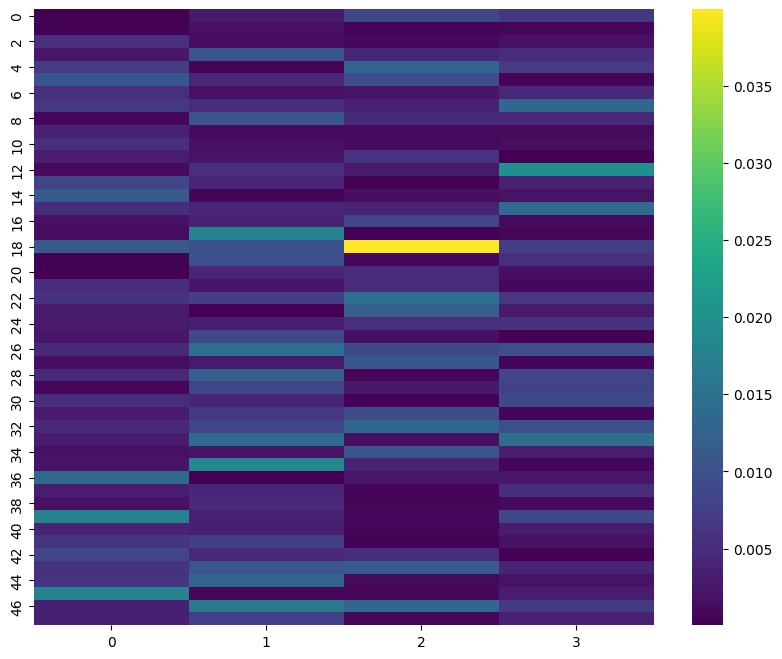

In [250]:
plt.figure(figsize=(10,8))
sns.heatmap(q_func._q_table, cmap='viridis')
plt.show()

### 开始训练；可以使用 tensorboard --logdir ./logs 查看当前loss函数

In [251]:
q_trainer.train(epoch_cnt=TRAIN_EPOCH, max_steps=500)

100%|██████████| 5000/5000 [00:17<00:00, 288.08it/s]


#### 结束后看下训练完成的数据

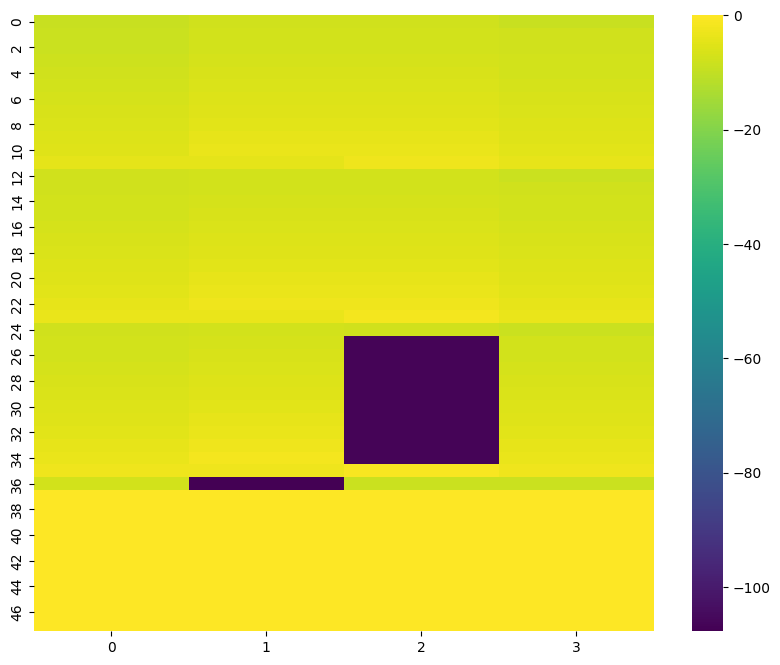

In [263]:
plt.figure(figsize=(10,8))
sns.heatmap(q_func._q_table, cmap='viridis')
plt.show()

#### 创建验证器

In [257]:
t = QFuncTester(
    q_func,
    Env(gym.make(GYM_ENV_NAME, render_mode="human"))
)

#### 开始可视化推理; 在PORTS 中默认会有6080的VNC端口转发，打开该forward port对应的web，密码vscode，即可登录GUI环境

In [264]:
t.test(max_step=30)

Test reward: -13
